## Using Microwave soundings to retrieve temperature
If we know the exact mixing ratio of a trace gase, we can invert a temperature profile from spectra in the thermal domain. At 2 wavenumbers (around 55GHz), there are oxygen features in an otherwise clean atmospheric window.
How can spectra in this domain be used to invert temperature? 
The following script should provide some insights, using lessons learned for thermal infrared retrievals. In this spectral range, we can ignore clouds and aerosols. Why?

Please also see Garand et al (JGR, in Materials folder) as well as
http://images.remss.com/papers/msu/MSU_AMSU_C-ATBD.pdf (Fig 1)

#### I cleaned up that part, most import commands as well as some routines are now just imported.  

In [1]:
## Make sure plots are create inline
%matplotlib inline
## The usual packages (numpy, matplotlib, etc)
from RSE_style import *
# Import some tools (like getAtmosphere, Planck)
from RS_ESE import *
# Import HAPI interface
from hapi import *


HAPI version: 1.1.0.8.7
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005


In [2]:
# Get O2 cross sections between 1-3 wavenumbers.
fetch('O2',7,1,1,3)


Data is fetched from http://hitran.org

BEGIN DOWNLOAD: O2
  65536 bytes written to ./O2.data
Header written to ./O2.header
END DOWNLOAD
                     Lines parsed: 83
PROCESSED


#### Let us just plot line strengths that we just extracted to see where the transitions are

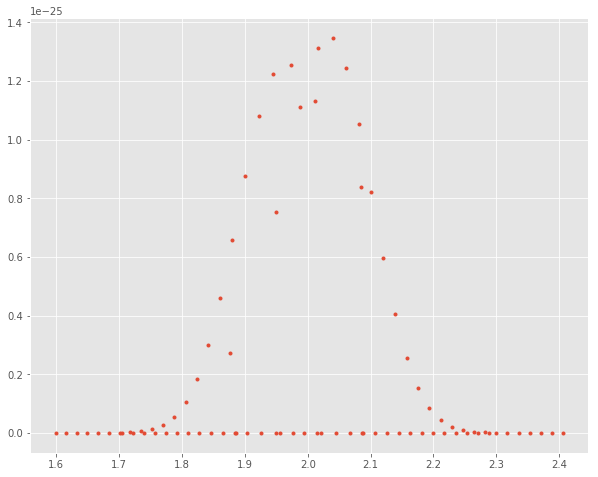

In [6]:
figsize(10,8)
nu_,sw_ = getColumns('O2',['nu','sw'])
plt.plot(nu_,sw_,'.')

#### For illustration, we now look at cross sections at a couple of different pressure levels. 
You will see that the higher pressure data almost looks like a continuum absorption as the pressure broadening is very dominant, basically smoothing over multiple absorption lines

In [7]:
nu_, cs_o2_10hPa = absorptionCoefficient_Voigt(SourceTables='O2', WavenumberRange=[1.6,2],Environment={'p':0.01,'T':293},WavenumberStep=0.0002,WavenumberWing=40)
nu_, cs_o2_30hPa = absorptionCoefficient_Voigt(SourceTables='O2', WavenumberRange=[1.6,2],Environment={'p':0.03,'T':293},WavenumberStep=0.0002,WavenumberWing=40)
nu_, cs_o2_100hPa = absorptionCoefficient_Voigt(SourceTables='O2', WavenumberRange=[1.6,2],Environment={'p':0.1,'T':293},WavenumberStep=0.0002,WavenumberWing=40)
nu_, cs_o2_300hPa = absorptionCoefficient_Voigt(SourceTables='O2', WavenumberRange=[1.6,2],Environment={'p':0.3,'T':293},WavenumberStep=0.0002,WavenumberWing=40)
nu_, cs_o2_1000hPa = absorptionCoefficient_Voigt(SourceTables='O2', WavenumberRange=[1.6,2],Environment={'p':1,'T':293},WavenumberStep=0.0002,WavenumberWing=40)

Text(0.5,1,'O$_2$ Absorption cross sections')

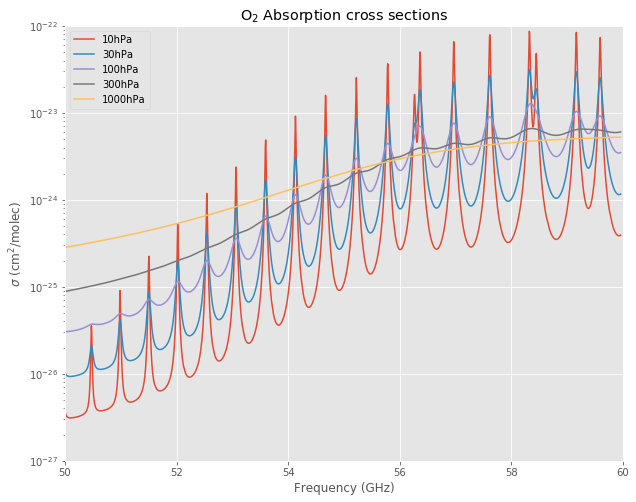

In [9]:
c = 299792458;
# Brute fore conversion to GhZ:
wl = 1e7/nu_  # in nm
freq = c/(wl) # in GHz

plt.semilogy(freq ,cs_o2_10hPa,label='10hPa')
plt.semilogy(freq ,cs_o2_30hPa,label='30hPa')
plt.semilogy(freq ,cs_o2_100hPa,label='100hPa')
plt.semilogy(freq ,cs_o2_300hPa,label='300hPa')
plt.semilogy(freq ,cs_o2_1000hPa,label='1000hPa')
plt.xlim((50,60))
plt.legend(loc=0)
plt.ylim((1e-27,1e-22))
plt.xlabel('Frequency (GHz)')
plt.ylabel('$\sigma$ (cm$^2$/molec)')
plt.title('O$_2$ Absorption cross sections')

#### I now outsourced the tediously long part to extract the atmospheric properties into a separate function. 
Check out the script yourself. If you have MERRA data, you could just provide another filename as well as input variable. Eventually, I would prefer to use an Atmosphere "Class" that has all the necessary variables stored as member but also includes some function calls within the class. 
See, for instance
http://python-textbok.readthedocs.io/en/1.0/Object_Oriented_Programming.html
https://jeffknupp.com/blog/2014/06/18/improve-your-python-python-classes-and-object-oriented-programming/

In [10]:
p_full, T_local, VCD_dry, NLEV, vmr_h2o,dz = getAtmosphere(34.1377,-118.1253)

Total column density of dry air: 2.0461496375873158e+25 molec/cm^2
Total column density of water vapor: 1.1346336126054524e+23 molec/cm^2


In [11]:
# Let us generate a matrix again to save the cross sections per frequency and atmospheric layer:
cs_matrix_o2 = np.zeros((len(nu_),NLEV))

In [12]:
# Run a loop through all atmospheric layers to then retrieve the cross sections at the particular layer:
for i in range(NLEV):
 #   print i
    p_ = p_full[i]/1013. # Remember, HITRAN uses Atm as unit, not hPa
    T_ = T_local[i]      # Kelvin is used here.
    nu_, cs_o2 = absorptionCoefficient_Voigt(SourceTables='O2', WavenumberRange=[1.6,2],Environment={'p':p_,'T':T_},WavenumberStep=0.0002)
    cs_matrix_o2[:,i] = cs_o2 # Fill in matrix at layer i

#### Computing transmission per layer
Now we can easily compute the transmission matrix (again, frequency and layer as dimensions). 

Optical density per layer is $\tau_i = VCD_i * \sigma(T_i,p_i)$, with $VCD_i$ being $VCD_{dryAir}\cdot VMR_{gas}$.
Transmission is then simply $\exp(-\tau)$ and $VMR$ of O$_2$ is set to 21%.

In [13]:
# Compute transmission for each layer:
T = np.zeros((len(nu_),NLEV))
# Generate matrices of optical thickness per layer now for each gas: 
tau_o2 = cs_matrix_o2*VCD_dry*0.21

In [14]:
# Compute Tranmission (python can do this with a matrix, just does this element by element)
T = exp(-tau_o2)

(48, 60)

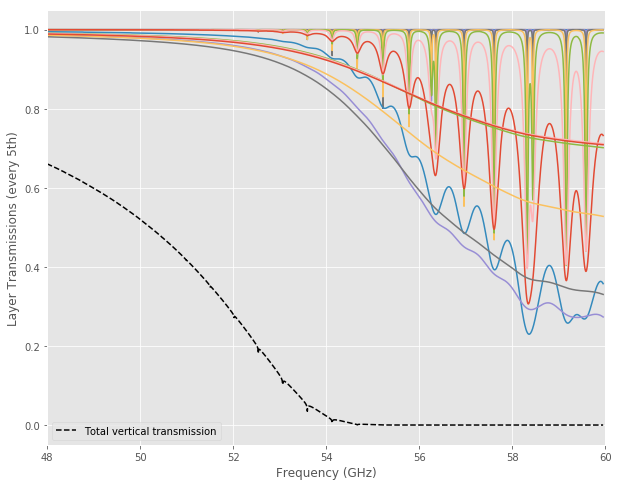

In [15]:
plt.plot(freq,T[:,0:-1:5])
# Total atmospheric transmission is just the product of all layers, plot this in dashed black:
plt.plot(freq,np.prod(T,axis=1),'--k',label='Total vertical transmission')
plt.legend(loc=0)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Layer Transmissions (every 5th)')
plt.xlim((48,60))

In [16]:
# Generate Planck curve per layer + surface:
wl_nu = 1.e7/nu_*1.e-9

# Use skin temperature of 310K, this is the surface contribution, setting emissivity to 1.
B_surf = planck(wl_nu,310)

# Generate matrix that computes the BlackBody radiance per layer:
B = np.zeros((len(nu_),NLEV))
B_pert = np.zeros((len(nu_),NLEV))
for i in range(NLEV):
    B[:,i] = planck(wl_nu,T_local[i])
    B_pert[:,i] = planck(wl_nu,T_local[i]+1) 

### Computing surface contribution to TOA radiance:
The surface contribution to the TOA radiance is simply the surface blackbody radiance mumtiplied with the transmission of the vertical atmosphere (Could use a different view angle here if we wanted but use pure Nadir for simplicity)

In [17]:
R_surf = np.prod(T,axis=1)*B_surf

Text(0.5,1,'Surface contribution to TOA radiance')

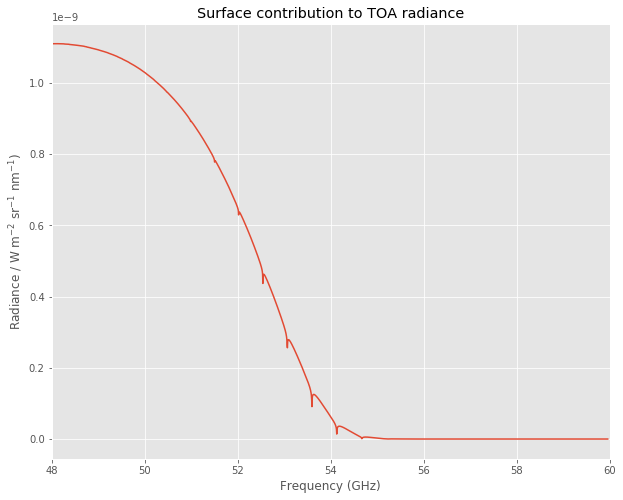

In [19]:
# Ok, let's just plot the surface contribution at TOA (which is almost 0 > 54 GHz)
plt.plot(freq,R_surf) #NADA
plt.xlabel('Frequency (GHz)')
plt.ylabel('Radiance / W m$^{-2}$ sr$^{-1}$ nm$^{-1}$)')
plt.xlim((48,60))
plt.title('Surface contribution to TOA radiance')

### Computing atmospheric contribution to TOA radiance:
Now we need to compute the atmospheric contribution to TIA radiance. Per isothermal layer $i$ and transmission per layer $\mathcal{T_i}$, this reads
$$R_i = B_\nu(T_i)\cdot(1-\mathcal{T_i}) \prod_{j=0}^{i-1} \mathcal{T_j}\,,$$
where the indexing goes from the top (index 0) to the bottom (index NLEV-1).
The total atmospheric contribution $R_{atmos}$ is simply the sum of these individual ones:
$$R_{atmos} = \sum_{i=0}^{NLEV-1} R_i$$

In [20]:
# Let us save individual contribution $R_i$ here:
R = np.zeros((len(nu_),NLEV))
R_pert = np.zeros((len(nu_),NLEV))
for i in range(NLEV):
    R[:,i] = B[:,i]*(1-T[:,i])*np.prod(T[:,0:i],axis=1)
    R_pert[:,i] = B_pert[:,i]*(1-T[:,i])*np.prod(T[:,0:i],axis=1)
    # See equation above and lecture material

Text(0.5,1,'TOA radiance')

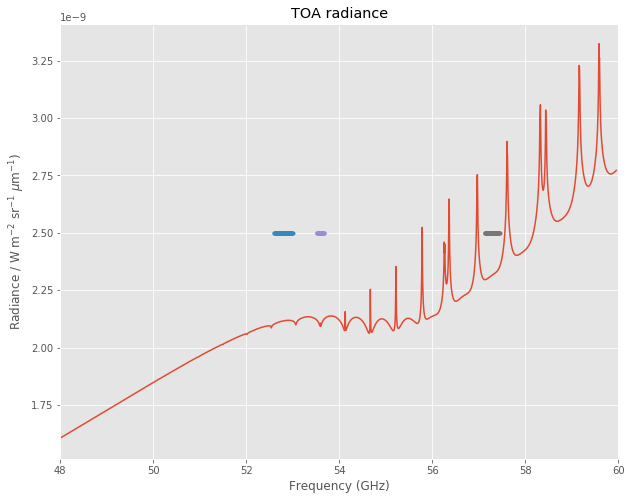

In [21]:
# We just define a couple of AMSU channels using a rectangular instrument function here, 
#i.e. just summing all radiances within the bins

amsu5 = np.where(np.abs(freq-53.596)<0.17/2.)[0]
amsu9 = np.where(np.abs(freq-57.290)<0.33/2.)[0]
amsu4 = np.where(np.abs(freq-52.800)<0.4/2.)[0]

# Now compute TOA radiance as sum of surface and atmospheric ontribution:
TOA = np.sum(R,axis=1)+R_surf

# and plot it:
plt.plot(freq,TOA,label='outgoing TOA radiance')#, wl_nu*1e6, np.sum(R,axis=1), wl_nu*1e6,R_surf)
plt.plot(freq[amsu4],freq[amsu4]*0+2.5e-9,'.',label='AMSU 4 channel')
plt.plot(freq[amsu5],freq[amsu5]*0+2.5e-9,'.',label='AMSU 5 channel')
plt.plot(freq[amsu9],freq[amsu9]*0+2.5e-9,'.',label='AMSU 7 channel')

plt.xlabel('Frequency (GHz)')
plt.ylabel('Radiance / W m$^{-2}$ sr$^{-1}$ $\mu$m$^{-1}$)')
plt.xlim((48,60))
plt.title('TOA radiance')

### Where do most of the radiance come from?
For this, we can just plot the vertical cross section of TOA contributions for the different frequency ranges per AMSU band:

Text(0,0.5,'Pressure (hPa)')

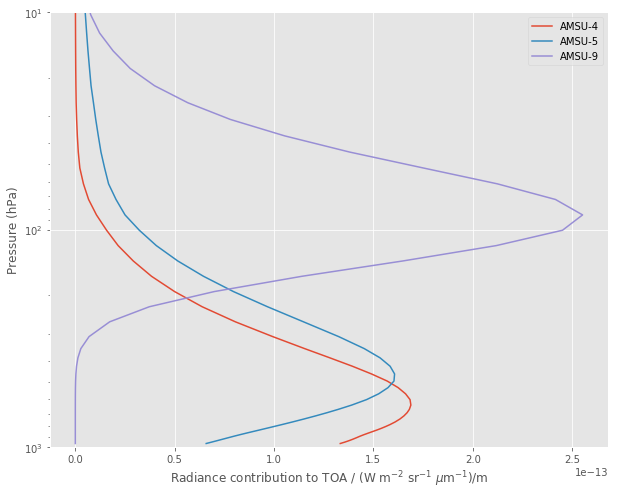

In [22]:
plt.semilogy(np.mean(R[amsu4,:],axis=0)/dz,p_full,label='AMSU-4')
plt.semilogy(np.mean(R[amsu5,:],axis=0)/dz,p_full,label='AMSU-5')
plt.semilogy(np.mean(R[amsu9,:],axis=0)/dz,p_full,label='AMSU-9')
plt.legend()
plt.ylim((1000,10))
plt.xlabel('Radiance contribution to TOA / (W m$^{-2}$ sr$^{-1}$ $\mu$m$^{-1}$)/m')
plt.ylabel('Pressure (hPa)')

### Let us plot this in $\tau$ coordinates:
where $\tau(z)$ is the integrated optical depths from TOA ($\tau=0$) to height z. As we have learned before, the mean free path of a photon in a medium with extinction coefficient $k$ is just:
$$\langle mfp \rangle = \frac{1}{k}$$
This means that 
$$\underbrace{\langle mfp \rangle \cdot k}_{\tau_{\langle mfp \rangle}} = 1$$
I.e. the mean free path corresponds roughly to the distance in which the optical density of 1 is reached! 

Text(0,0.5,'$\\tau$')

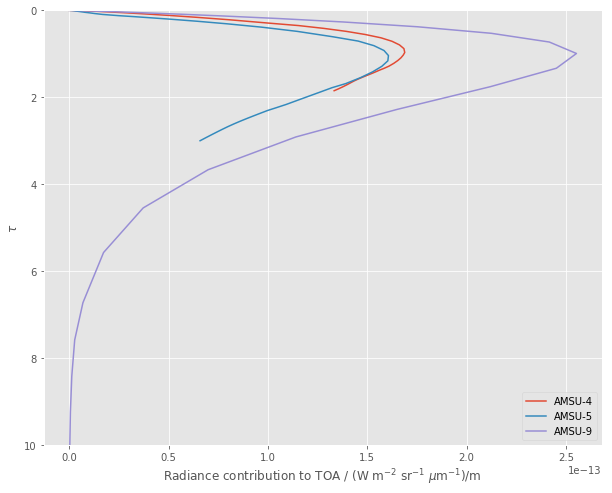

In [23]:
# Let us just first average taus per band:
tau4 = np.mean(tau_o2[amsu4,:],axis=0)
tau5 = np.mean(tau_o2[amsu5,:],axis=0)
tau9 = np.mean(tau_o2[amsu9,:],axis=0)

plt.plot(np.mean(R[amsu4,:],axis=0)/dz,np.cumsum(tau4),label='AMSU-4')
plt.plot(np.mean(R[amsu5,:],axis=0)/dz,np.cumsum(tau5),label='AMSU-5')
plt.plot(np.mean(R[amsu9,:],axis=0)/dz,np.cumsum(tau9),label='AMSU-9')
plt.legend(loc=0)
plt.ylim((10,0))
plt.xlabel('Radiance contribution to TOA / (W m$^{-2}$ sr$^{-1}$ $\mu$m$^{-1}$)/m')
plt.ylabel(r'$\tau$')

#### Plotting many different contributions (at full line-by-line resolution, no line-shape)
E.g. like we had the perfect full-range high-resolution spectrometer.

Text(0,0.5,'Pressure (hPa)')

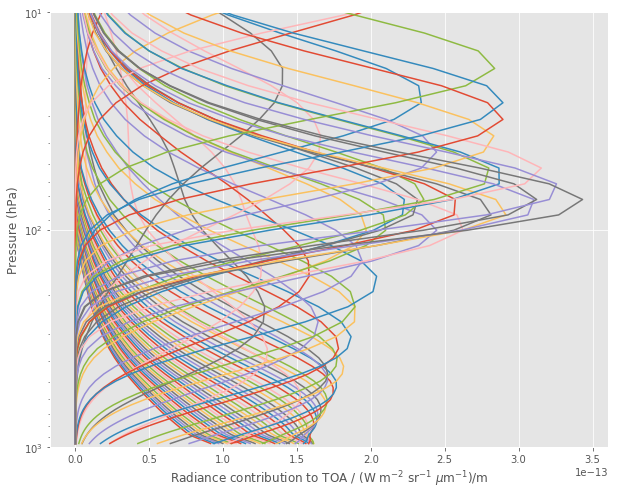

In [24]:
for i in np.arange(0,len(nu_),25):
    plt.semilogy(R[i,:]/dz,p_full,label='AMSU-9')
plt.ylim((1000,10))
plt.xlabel('Radiance contribution to TOA / (W m$^{-2}$ sr$^{-1}$ $\mu$m$^{-1}$)/m')
plt.ylabel(r'Pressure (hPa)')

#### again, as function of $\tau$
Most peak at tau=1 but there are some difference as the y-coordinate now corresponds to different temperatures. 

Text(0,0.5,'$\\tau$')

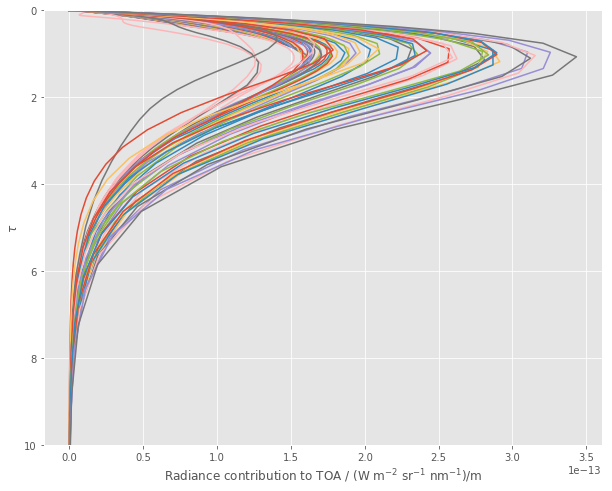

In [26]:
for i in np.arange(0,len(nu_),25):
    plt.plot(R[i,:]/dz,np.cumsum(tau_o2[i,:]))
    
plt.ylim((10,0))
plt.xlabel('Radiance contribution to TOA / (W m$^{-2}$ sr$^{-1}$ nm$^{-1}$)/m')
plt.ylabel(r'$\tau$')

### How can you use this to invert temperature? To what layers are the bands most sensitive to?

Text(0,0.5,'Pressure (hPa)')

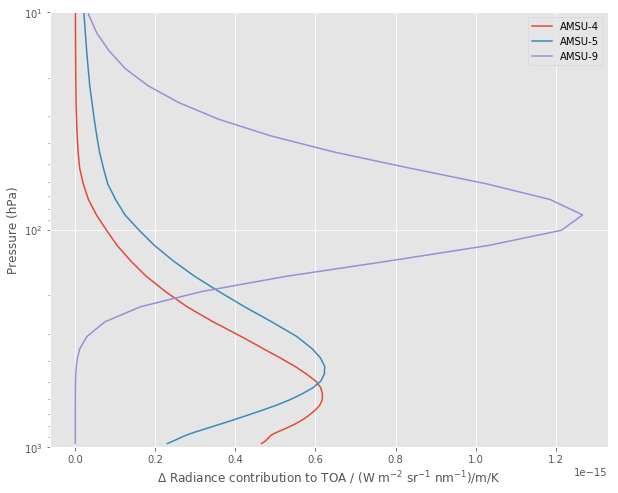

In [28]:
#plt.semilogy(np.mean(R[amsu4,:],axis=0)/dz,p_full,label='AMSU-4')
#plt.semilogy(np.mean(R[amsu5,:],axis=0)/dz,p_full,label='AMSU-5')
#plt.semilogy(np.mean(R[amsu9,:],axis=0)/dz,p_full,label='AMSU-9')
plt.semilogy(np.mean(R_pert[amsu4,:],axis=0)/dz-np.mean(R[amsu4,:],axis=0)/dz,p_full,label='AMSU-4')
plt.semilogy(np.mean(R_pert[amsu5,:],axis=0)/dz-np.mean(R[amsu5,:],axis=0)/dz,p_full,label='AMSU-5')
plt.semilogy(np.mean(R_pert[amsu9,:],axis=0)/dz-np.mean(R[amsu9,:],axis=0)/dz,p_full,label='AMSU-9')
plt.legend()
plt.ylim((1000,10))
plt.xlabel('$\Delta$ Radiance contribution to TOA / (W m$^{-2}$ sr$^{-1}$ nm$^{-1}$)/m/K')
plt.ylabel('Pressure (hPa)')